In [1]:
import pyddm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# AF-TODO
# 1. Figure out where lower bound is applied (seems like pdf pre-nondecision time is evaluating to 0.0005, seems weird!)
def drift_fun(x, leak, driftrate):
    return driftrate - (x*leak)

def bound_fun(t, initial_B, collapse_rate):
    return initial_B * np.exp(-collapse_rate * t)


model = pyddm.gddm(drift=drift_fun,
                   bound=bound_fun,
                   starting_position="x0",
                   nondecision="nondectime",
                   mixture_coef = 0.0,
                #    overlay=None,
                   T_dur = 20,
                   dt = 0.001,
                   parameters={"leak": (0, 2),
                               "driftrate": (-3, 3),
                               "initial_B": (.5, 3.0),
                               "collapse_rate": (0, 10),
                               "x0": (-.9, .9),
                               "nondectime": (0, 2),
                   }
                  )

In [3]:
param_dict = {"leak": 0.1,
              "driftrate": 1.0,
              "initial_B": 2.5,
              "collapse_rate": 0.2,
              "x0": 0,
              "nondectime": 1.0,
              }

new_params = []
for name_, param_ in zip(model.get_model_parameter_names(), model.get_model_parameters()):
    print(name_, param_)
    new_params.append(param_dict[name_])

model.set_model_parameters(new_params)

leak Fittable(minval=0, maxval=2)
driftrate Fittable(minval=-3, maxval=3)
initial_B Fittable(minval=0.5, maxval=3.0)
collapse_rate Fittable(minval=0, maxval=10)
x0 Fittable(minval=-0.9, maxval=0.9)
nondectime Fittable(minval=0, maxval=2)


In [4]:
# %%timeit
model.solve().pdf(choice = "correct")

array([0., 0., 0., ..., 0., 0., 0.], shape=(20001,))

In [5]:
t_dom = model.t_domain()
pdf_out = model.solve().pdf(choice = "correct")

from scipy import integrate

result = integrate.trapezoid(pdf_out, t_dom)
print(result)

0.9719323404173694


In [21]:
t_dom[t_dom > deadline]

array([ 2.001,  2.002,  2.003, ..., 19.998, 19.999, 20.   ],
      shape=(18000,))

In [22]:
pdf_out

array([0., 0., 0., ..., 0., 0., 0.], shape=(20001,))

In [ ]:
%%timeit

deadline = 21.0
n_trials = 1

sol = model.solve()
sol_corr = sol.pdf(choice = "correct")
sol_err = sol.pdf(choice = "error")

choice_p = np.zeros((n_trials, 2))
choice_p_pre_deadline = np.zeros((n_trials, 2))
choice_p_post_deadline = np.zeros((n_trials, 2))
choice_p_no_omission = np.zeros((n_trials, 2))

map_choices = {0: "error", 1: "correct"}
if deadline >= t_dom[-1]:
    choice_p[0, 0] = sol.prob("error")
    choice_p[0, 1] = sol.prob("correct")

    choice_p_no_omission[0, 0] = choice_p[0, 0]
    choice_p_no_omission[0, 1] = choice_p[0, 1]

    nogo_p = choice_p[0, 0]
    go_p = choice_p[0, 1]

    omission_p = 0.0
else:
    choice_p_pre_deadline[0, 0] = integrate.simpson(sol_err[t_dom < deadline],
                                                     t_dom[t_dom < deadline])
    choice_p_post_deadline[0, 0] = sol.prob("error") - \
        choice_p_pre_deadline[0, 0]
    
    choice_p_pre_deadline[0, 1] = integrate.simpson(sol_corr[t_dom < deadline],
                                                     t_dom[t_dom < deadline])
    choice_p_post_deadline[0, 1] = sol.prob("correct") - \
        choice_p_pre_deadline[0, 1]

    choice_p[0, 0] = choice_p_pre_deadline[0, 0]
    choice_p[0, 1] = choice_p_pre_deadline[0, 1]

    choice_p_no_omission[0, 0] = choice_p_pre_deadline[0, 0] / \
        (choice_p_pre_deadline[0, 0] + choice_p_pre_deadline[0, 1])
    choice_p_no_omission[0, 1] = choice_p_pre_deadline[0, 1] / \
        (choice_p_pre_deadline[0, 0] + choice_p_pre_deadline[0, 1])
    
    nogo_p = choice_p_post_deadline[0, 1] + choice_p[0, 0]
    go_p = 1 - nogo_p

    omission_p = choice_p_post_deadline[0, 0] + choice_p_post_deadline[0, 1]

for i in range(2):
    choice_p = integrate.simpson(sol_err)
    choice_p_no_omission

# result_trap = integrate.trapezoid(pdf_out[t_dom >= deadline], t_dom[t_dom >= deadline])

55 μs ± 2 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


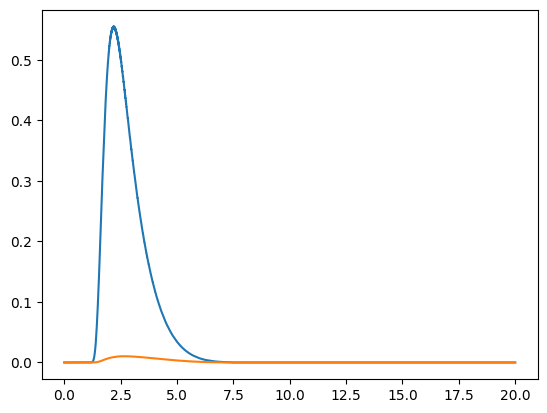

In [10]:
plt.plot(t_dom, sol_corr)
plt.plot(t_dom, sol_err)

In [11]:
omission_p

np.float64(0.8178603487705772)

np.float64(0.02796777444520068)

In [26]:
print(result_simps, result_trap)

0.7920721027816701 0.792071988694645


In [59]:
from scipy.interpolate import interp1d

pdf_interp_cub = interp1d(t_dom, pdf_out, kind = "cubic")
pdf_interp_lin = interp1d(t_dom, pdf_out, kind = "linear")

# result_cub = integrate.trapezoid(pdf_interp_cub(t_dom), t_dom)
# result_lin = integrate.trapezoid(pdf_interp_lin(t_dom), t_dom)

# print(result_cub, result_lin)

In [60]:
pdf_interp_lin(0.01)

array(0.)

In [61]:
my_t = np.linspace(0, 20, 1000000)
my_pdf_out_cub = pdf_interp_cub(my_t)
my_pdf_out_lin = pdf_interp_lin(my_t)

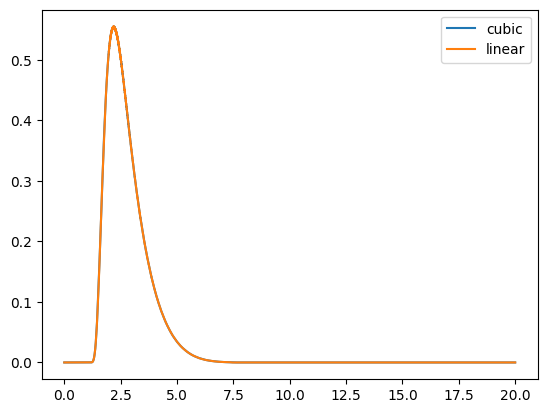

In [62]:
plt.plot(my_t, my_pdf_out_cub, label = "cubic")
plt.plot(my_t, my_pdf_out_lin, label = "linear")
# plt.xlim(0.3, 0.301)
# plt.ylim(2.06, 2.08)
plt.legend()

In [63]:
model.solve().pdf(choice = "correct")

array([0., 0., 0., ..., 0., 0., 0.], shape=(20001,))

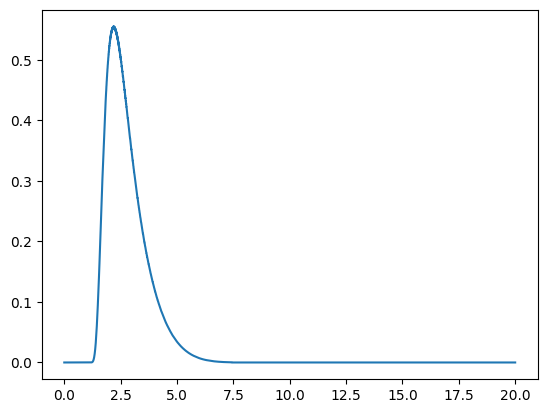

In [64]:
plt.plot(model.solve().t_domain, model.solve().pdf_corr())

(6.0, 7.7)

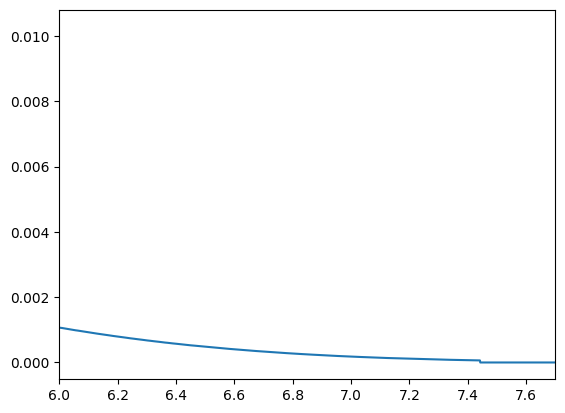

In [65]:
plt.plot(model.solve().t_domain, model.solve().pdf_err())
plt.xlim(6.0, 7.7)

In [66]:
model.solve().pdf_err()[7400:7500]

array([7.00004129e-05, 6.98037454e-05, 6.96341828e-05, 6.95159345e-05,
       6.93854744e-05, 6.92413196e-05, 6.90891465e-05, 6.89314318e-05,
       6.87696104e-05, 6.86045969e-05, 6.84370173e-05, 6.82673246e-05,
       6.80958609e-05, 6.79228936e-05, 6.77486375e-05, 6.75732687e-05,
       6.73969346e-05, 6.72197603e-05, 6.70418536e-05, 6.68633081e-05,
       6.66842062e-05, 6.65046208e-05, 6.63246171e-05, 6.61442535e-05,
       6.59635830e-05, 6.57826536e-05, 6.56015092e-05, 6.54201898e-05,
       6.52387324e-05, 6.50571710e-05, 6.48755372e-05, 6.46938602e-05,
       6.45121671e-05, 6.43304833e-05, 6.41488325e-05, 6.39672367e-05,
       6.37857168e-05, 6.36042920e-05, 6.34398997e-05, 6.33303809e-05,
       6.32103683e-05, 6.30773395e-05, 6.29368135e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [52]:
model.solve().pdf_corr()[7400:7500]

array([0.00077962, 0.00077877, 0.00077801, 0.00077744, 0.00077683,
       0.00077617, 0.00077547, 0.00077475, 0.00077402, 0.00077328,
       0.00077252, 0.00077176, 0.000771  , 0.00077023, 0.00076945,
       0.00076867, 0.00076789, 0.00076711, 0.00076633, 0.00076554,
       0.00076475, 0.00076397, 0.00076318, 0.00076239, 0.0007616 ,
       0.00076081, 0.00076002, 0.00075924, 0.00075845, 0.00075766,
       0.00075688, 0.00075609, 0.00075531, 0.00075452, 0.00075374,
       0.00075296, 0.00075218, 0.0007514 , 0.00075068, 0.00075016,
       0.00074961, 0.000749  , 0.00074837, 0.00049998, 0.00049998,
       0.00049998, 0.00049998, 0.00049998, 0.00049998, 0.00049998,
       0.00049998, 0.00049998, 0.00049998, 0.00049998, 0.00049998,
       0.00049998, 0.00049998, 0.00049998, 0.00049998, 0.00049998,
       0.00049998, 0.00049998, 0.00049998, 0.00049998, 0.00049998,
       0.00049998, 0.00049998, 0.00049998, 0.00049998, 0.00049998,
       0.00049998, 0.00049998, 0.00049998, 0.00049998, 0.00049

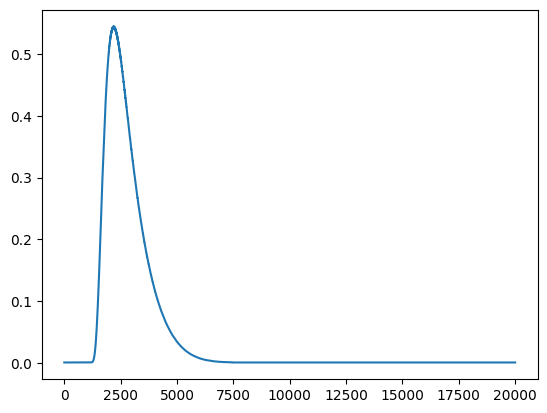

In [45]:
plt.plot(model.solve().pdf_corr())

In [69]:
sol = model.solve()
samples = sol.resample(10000)

(array([  7.,  12.,  37.,  54.,  92., 137., 173., 205., 255., 269., 279.,
        316., 318., 335., 326., 311., 317., 332., 333., 299., 301., 291.,
        292., 272., 275., 237., 228., 234., 207., 192., 186., 178., 171.,
        148., 151., 143., 122., 119., 118., 108.,  99.,  94.,  75.,  76.,
         75.,  68.,  71.,  59.,  63.,  59.,  53.,  47.,  38.,  40.,  28.,
         28.,  28.,  26.,  27.,  22.,  17.,  29.,  11.,  13.,  15.,  10.,
         14.,  14.,  11.,   9.,  13.,  13.,   5.,  10.,   5.,   4.,   5.,
          1.,   3.,   3.,   3.,   4.,   1.,   1.,   4.,   0.,   3.,   2.,
          1.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,
          1.]),
 array([1.28440556, 1.34541038, 1.4064152 , 1.46742002, 1.52842484,
        1.58942966, 1.65043448, 1.7114393 , 1.77244412, 1.83344894,
        1.89445376, 1.95545858, 2.0164634 , 2.07746822, 2.13847304,
        2.19947786, 2.26048269, 2.32148751, 2.38249233, 2.44349715,
        2.50450197, 2.56550679, 2.62651161, 2.

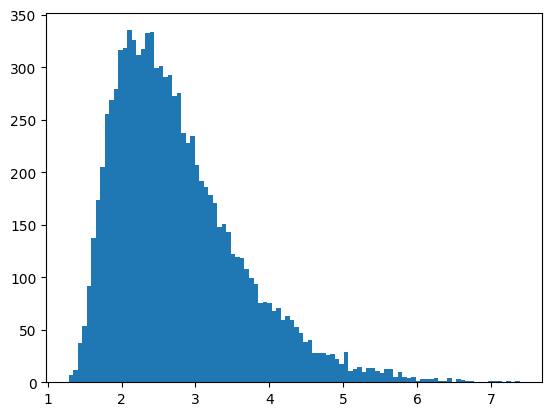

In [ ]:
plt.hist(samples.choice_upper,
         bins = 100)

AttributeError: Rectangle.set() got an unexpected keyword argument 'type'

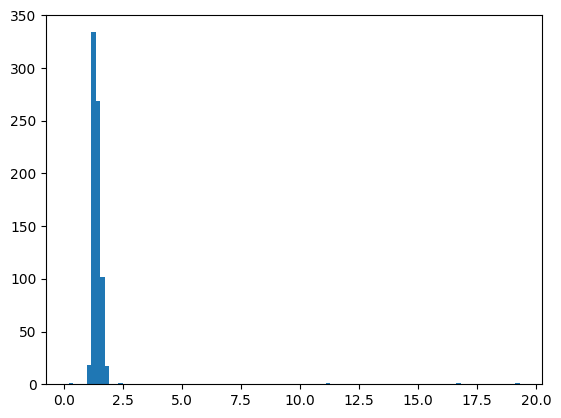

In [ ]:
plt.hist(samples.choice_upper, bins = 100)

In [ ]:
samples.pdf

<bound method Sample.pdf of <pyddm.sample.Sample object at 0x135ad9b90>>

In [41]:
model.get_model_parameter_names()

['leak', 'driftrate', 'initial_B', 'collapse_rate', 'x0']

In [ ]:
cnt = 0
for i in model.get_model_parameters()[0]._generate():
    print(i)
    cnt += 1
    if cnt > 10:
        break


Fittable()
Fittable(minval=1)
Fittable(maxval=3)
Fittable(minval=-1, maxval=1)
Fittable()
Fittable(minval=3)
Fittable(minval=10, maxval=100)
Fitted(0.0)
Fitted(1.0)
Fitted(4.0, minval=0, maxval=10)


In [32]:
model.get_model_parameters()[0]

Fittable(minval=0, maxval=2)